# IA Propensity Train.

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, precision_score, recall_score, f1_score
)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import (
    train_test_split, cross_val_score, learning_curve, validation_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


sns.set_theme(style="whitegrid")

: 

In [102]:
df = pd.read_csv("data\IA_PROPENSITY_TRAIN.csv", index_col=0)
df.head()

,PRODUCTO,TIPO_CARROCERIA,COMBUSTIBLE,Potencia,TRANS,FORMA_PAGO,ESTADO_CIVIL,GENERO,OcupaciOn,PROVINCIA,...,REV_Garantia,Averia_grave,QUEJA_CAC,EDAD_COCHE,COSTE_VENTA,km_anno,Mas_1_coche,Revisiones,Edad_Cliente,Tiempo
CODE,,,,,,,,,,,,,,,,,,,,,
CLI1,A,TIPO1,FUEL 1,Baja,M,Contado,CASADO,M,Empresa,Asturias,...,NO DATA,Averia muy grave,SI,208,2892,0,0,2,18,0
CLI2,A,TIPO1,FUEL 1,Baja,M,Contado,CASADO,F,Empresa,Toledo,...,SI,No,NO,245,1376,7187,0,2,53,0
CLI3,A,TIPO1,FUEL 1,Baja,M,Otros,CASADO,M,Empresa,Lerida,...,NO DATA,No,NO,251,1376,0,1,4,21,3
CLI4,A,TIPO1,FUEL 1,Baja,M,Financiera Marca,CASADO,F,Empresa,Madrid,...,SI,Averia muy grave,SI,243,2015,7256,1,4,48,5
CLI5,A,TIPO1,FUEL 1,Baja,M,Financiera Marca,CASADO,F,Funcionario,Santa Cruz de Tenerife,...,NO DATA,No,NO,23,1818,0,1,3,21,3


In [103]:
df.shape

(58049, 24)

In [104]:
df.dtypes

PRODUCTO           object
TIPO_CARROCERIA    object
COMBUSTIBLE        object
Potencia           object
TRANS              object
FORMA_PAGO         object
ESTADO_CIVIL       object
GENERO             object
OcupaciOn          object
PROVINCIA          object
Campanna1          object
Campanna2          object
Campanna3          object
Zona_Renta         object
REV_Garantia       object
Averia_grave       object
QUEJA_CAC          object
EDAD_COCHE          int64
COSTE_VENTA         int64
km_anno             int64
Mas_1_coche         int64
Revisiones          int64
Edad_Cliente        int64
Tiempo              int64
dtype: object

## Gráficas

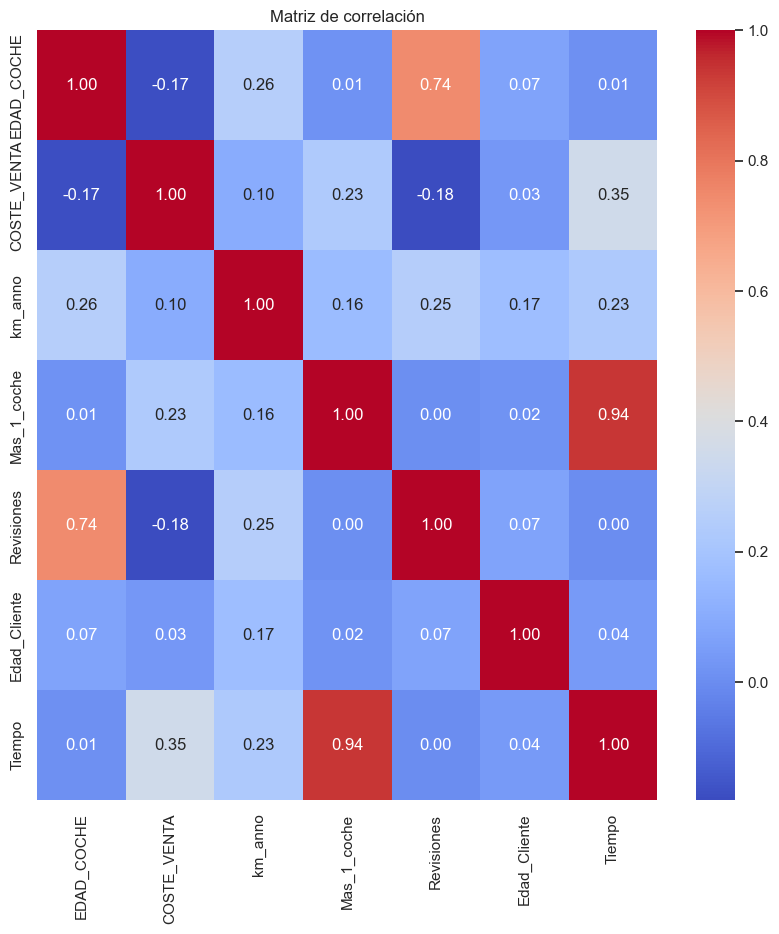

In [105]:
# Matriz de correlación
corr = df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación")
plt.show()

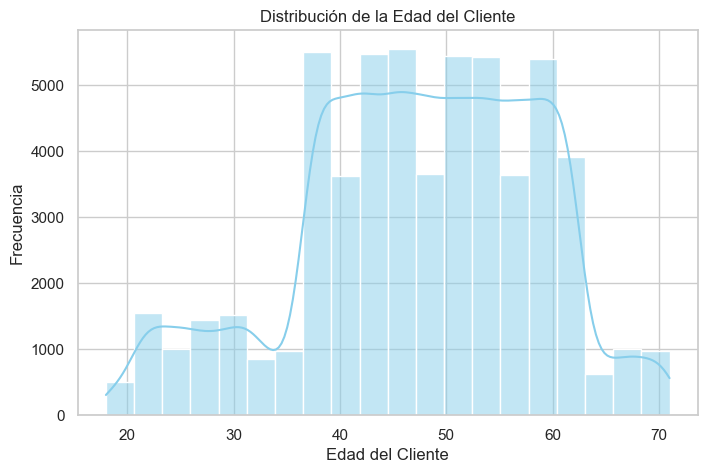

In [106]:
# Histograma de la distribución de la edad del cliente
plt.figure(figsize=(8, 5))
sns.histplot(df["Edad_Cliente"], bins=20, kde=True, color="skyblue")
plt.title("Distribución de la Edad del Cliente")
plt.xlabel("Edad del Cliente")
plt.ylabel("Frecuencia")
plt.show()

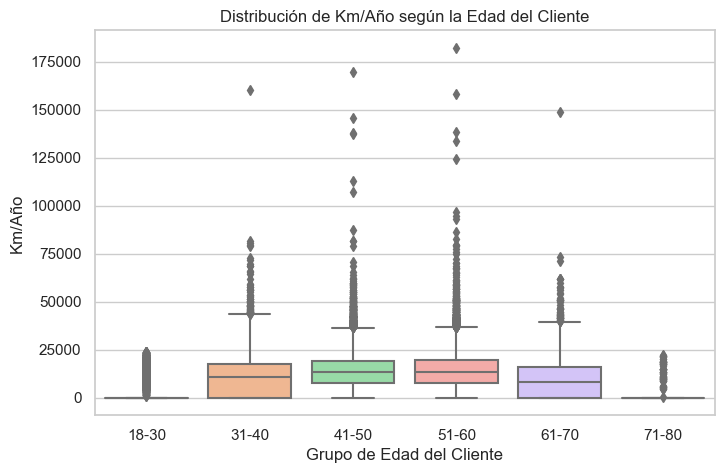

In [107]:
# Boxplot de kilómetros por año según la edad del cliente (agrupada por décadas)
df["Grupo_Edad"] = pd.cut(df["Edad_Cliente"], bins=[18, 30, 40, 50, 60, 70, 80], labels=["18-30", "31-40", "41-50", "51-60", "61-70", "71-80"])
plt.figure(figsize=(8, 5))
sns.boxplot(x="Grupo_Edad", y="km_anno", data=df, palette="pastel")
plt.title("Distribución de Km/Año según la Edad del Cliente")
plt.xlabel("Grupo de Edad del Cliente")
plt.ylabel("Km/Año")
plt.show()

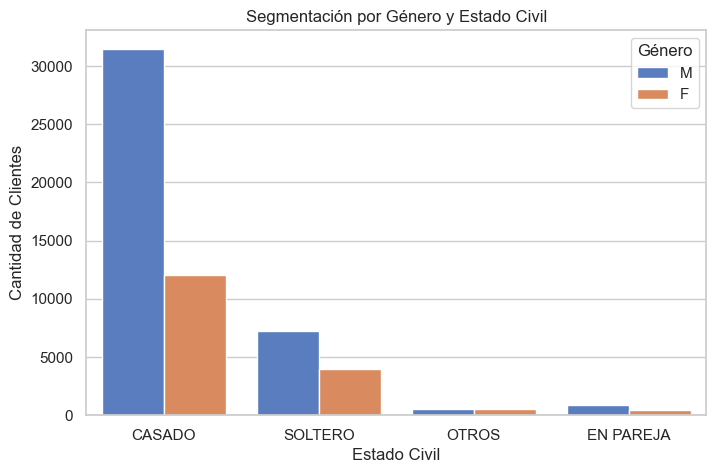

In [108]:
# Gráfico de barras de la cantidad de clientes por género y estado civil
plt.figure(figsize=(8, 5))
sns.countplot(x="ESTADO_CIVIL", hue="GENERO", data=df, palette="muted")
plt.title("Segmentación por Género y Estado Civil")
plt.xlabel("Estado Civil")
plt.ylabel("Cantidad de Clientes")
plt.legend(title="Género")
plt.show()

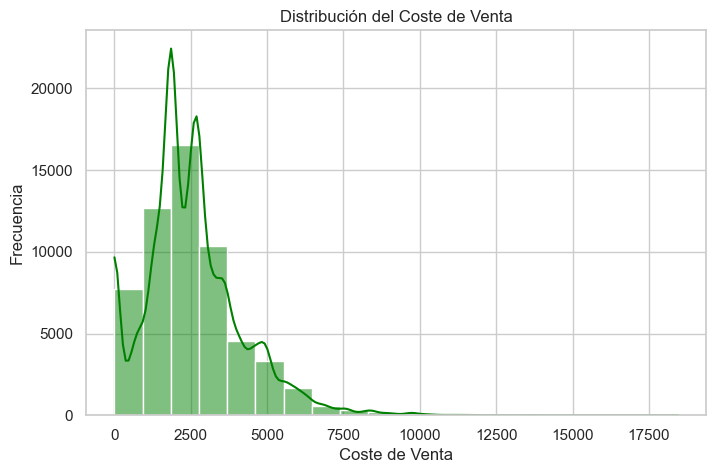

In [109]:
# Histograma del coste de venta
plt.figure(figsize=(8, 5))
sns.histplot(df["COSTE_VENTA"], bins=20, kde=True, color="green")
plt.title("Distribución del Coste de Venta")
plt.xlabel("Coste de Venta")
plt.ylabel("Frecuencia")
plt.show()

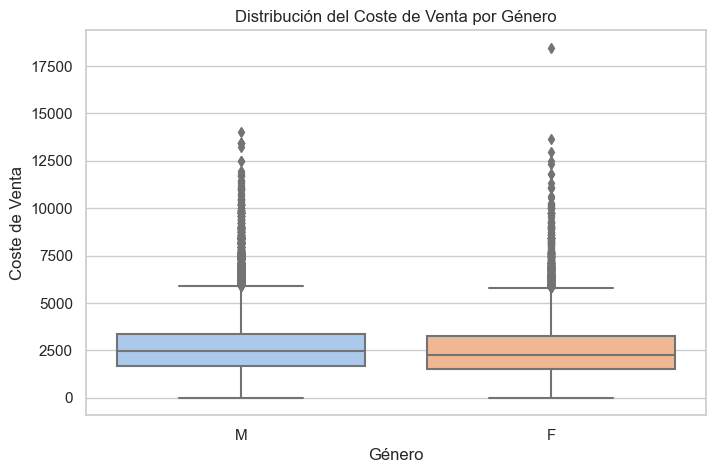

In [110]:
# Boxplot del coste de venta según el género
plt.figure(figsize=(8, 5))
sns.boxplot(x="GENERO", y="COSTE_VENTA", data=df, palette="pastel")
plt.title("Distribución del Coste de Venta por Género")
plt.xlabel("Género")
plt.ylabel("Coste de Venta")
plt.show()

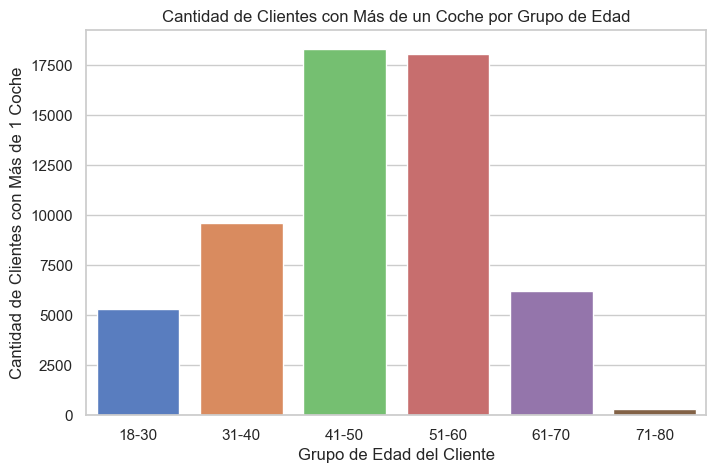

In [111]:
# Gráfico de barras: Cantidad de coches con más de un propietario según la edad del cliente
df["Mas_1_coche"] = np.random.choice([0, 1])
plt.figure(figsize=(8, 5))
sns.barplot(x="Grupo_Edad", y="Mas_1_coche", data=df, estimator=sum, palette="muted")
plt.title("Cantidad de Clientes con Más de un Coche por Grupo de Edad")
plt.xlabel("Grupo de Edad del Cliente")
plt.ylabel("Cantidad de Clientes con Más de 1 Coche")
plt.show()

## Entrenamiento del modelo

In [112]:
from sklearn.preprocessing import LabelEncoder

# Eliminar columnas irrelevantes
df.drop(['CODE', 'Tiempo'], axis=1, inplace=True, errors='ignore')

# Rellenar valores nulos
for column in df.select_dtypes(include=['object']).columns:
    df[column].fillna('Desconocido', inplace=True)  # Rellenar categóricas con 'Desconocido'

for column in df.select_dtypes(include=['int64', 'float64']).columns:
    df[column].fillna(df[column].median(), inplace=True)  # Rellenar numéricas con la mediana

# Separar características (X) y variable objetivo (y)
X = df.drop('Mas_1_coche', axis=1)
y = df['Mas_1_coche']

# Codificar variables categóricas
label_encoders = {}
for column in X.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    X[column] = label_encoders[column].fit_transform(X[column])

# Mostrar información después de la transformación
X_info = X.info()
y_info = y.info()

X_info, y_info

<class 'pandas.core.frame.DataFrame'>
Index: 58049 entries, CLI1 to CLI58048
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   PRODUCTO         58049 non-null  int32   
 1   TIPO_CARROCERIA  58049 non-null  int32   
 2   COMBUSTIBLE      58049 non-null  int32   
 3   Potencia         58049 non-null  int32   
 4   TRANS            58049 non-null  int32   
 5   FORMA_PAGO       58049 non-null  int32   
 6   ESTADO_CIVIL     58049 non-null  int32   
 7   GENERO           58049 non-null  int32   
 8   OcupaciOn        58049 non-null  int32   
 9   PROVINCIA        58049 non-null  int32   
 10  Campanna1        58049 non-null  int32   
 11  Campanna2        58049 non-null  int32   
 12  Campanna3        58049 non-null  int32   
 13  Zona_Renta       58049 non-null  int32   
 14  REV_Garantia     58049 non-null  int32   
 15  Averia_grave     58049 non-null  int32   
 16  QUEJA_CAC        58049 non-null  int32 

(None, None)

In [113]:
# Verificar si X tiene columnas categóricas no codificadas
categorical_columns = X.select_dtypes(include=['object']).columns

# Si hay columnas categóricas, volver a codificarlas
if len(categorical_columns) > 0:
    for column in categorical_columns:
        label_encoders[column] = LabelEncoder()
        X[column] = label_encoders[column].fit_transform(X[column])

# Verificar que todas las columnas sean numéricas ahora
X_info_final = X.info()
categorical_columns = X.select_dtypes(include=['object']).columns

X_info_final, categorical_columns

<class 'pandas.core.frame.DataFrame'>
Index: 58049 entries, CLI1 to CLI58048
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   PRODUCTO         58049 non-null  int32   
 1   TIPO_CARROCERIA  58049 non-null  int32   
 2   COMBUSTIBLE      58049 non-null  int32   
 3   Potencia         58049 non-null  int32   
 4   TRANS            58049 non-null  int32   
 5   FORMA_PAGO       58049 non-null  int32   
 6   ESTADO_CIVIL     58049 non-null  int32   
 7   GENERO           58049 non-null  int32   
 8   OcupaciOn        58049 non-null  int32   
 9   PROVINCIA        58049 non-null  int32   
 10  Campanna1        58049 non-null  int32   
 11  Campanna2        58049 non-null  int32   
 12  Campanna3        58049 non-null  int32   
 13  Zona_Renta       58049 non-null  int32   
 14  REV_Garantia     58049 non-null  int32   
 15  Averia_grave     58049 non-null  int32   
 16  QUEJA_CAC        58049 non-null  int32 

(None, Index([], dtype='object'))

In [114]:
df.drop(['Grupo_Edad'], axis=1, inplace=True, errors='ignore')

In [115]:
# Verificar valores únicos en Edad_Cliente
edad_cliente_unique_values = df['Edad_Cliente'].unique()

# Verificar el tipo de dato
edad_cliente_dtype = df['Edad_Cliente'].dtype

edad_cliente_unique_values, edad_cliente_dtype

(array([18, 53, 21, 48, 56, 24, 51, 44, 20, 32, 52, 55, 27, 26, 54, 38, 46,
        37, 31, 45, 23, 49, 57, 30, 39, 19, 29, 60, 28, 25, 58, 22, 50, 42,
        47, 62, 61, 59, 41, 40, 43, 64, 68, 67, 69, 70, 35, 71, 34, 66, 63,
        33, 65, 36], dtype=int64),
 dtype('int64'))

In [116]:
# Verificar si hay columnas categóricas en X (antes de dividir en train/test)
categorical_columns_in_X = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Mostrar valores únicos de estas columnas si existen
categorical_values = {col: X[col].unique() for col in categorical_columns_in_X} if categorical_columns_in_X else "No hay columnas categóricas."

categorical_columns_in_X, categorical_values

(['Grupo_Edad'],
 {'Grupo_Edad': [NaN, '51-60', '18-30', '41-50', '31-40', '61-70', '71-80']
  Categories (6, object): ['18-30' < '31-40' < '41-50' < '51-60' < '61-70' < '71-80']})

In [117]:
# Eliminar la columna 'Grupo_Edad' si existe
df.drop(columns=['Grupo_Edad'], axis=1, inplace=True, errors='ignore')

# Verificar que la columna fue eliminada
column_names_after_removal = df.columns.tolist()
column_names_after_removal

['PRODUCTO',
 'TIPO_CARROCERIA',
 'COMBUSTIBLE',
 'Potencia',
 'TRANS',
 'FORMA_PAGO',
 'ESTADO_CIVIL',
 'GENERO',
 'OcupaciOn',
 'PROVINCIA',
 'Campanna1',
 'Campanna2',
 'Campanna3',
 'Zona_Renta',
 'REV_Garantia',
 'Averia_grave',
 'QUEJA_CAC',
 'EDAD_COCHE',
 'COSTE_VENTA',
 'km_anno',
 'Mas_1_coche',
 'Revisiones',
 'Edad_Cliente']

In [122]:
# Enseñar columnas
columnas = df.columns.tolist()
columnas

['PRODUCTO',
 'TIPO_CARROCERIA',
 'COMBUSTIBLE',
 'Potencia',
 'TRANS',
 'FORMA_PAGO',
 'ESTADO_CIVIL',
 'GENERO',
 'OcupaciOn',
 'PROVINCIA',
 'Campanna1',
 'Campanna2',
 'Campanna3',
 'Zona_Renta',
 'REV_Garantia',
 'Averia_grave',
 'QUEJA_CAC',
 'EDAD_COCHE',
 'COSTE_VENTA',
 'km_anno',
 'Mas_1_coche',
 'Revisiones',
 'Edad_Cliente']

## Tabla de entrenamiento

In [118]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertir y_train a formato numérico
y_train = y_train.astype(int)

# Convertir y_test a formato numérico
y_test = y_test.astype(int)

## Iteración del modelo

In [120]:
# Definir hiperparámetros a iterar
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [ 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}
"""splitter="best" (por defecto)
Encuentra el mejor punto de división en cada nodo, basado en la métrica de evaluación (criterion).
Tiende a crear árboles más profundos, porque optimiza cada división localmente.
Útil para conjuntos de datos pequeños.
splitter="random". En lugar de buscar el mejor punto de división, elige un punto de división de manera aleatoria 
entre los mejores candidatos.
Puede generar árboles más pequeños y con menos sobreajuste.
Útil para conjuntos de datos grandes o cuando se usa en bagging/random forests.
----------------------------------------------------
Define el número mínimo de muestras necesarias para dividir un nodo.
Si min_samples_split=2, cualquier nodo con 2 o más muestras puede dividirse.
Si min_samples_split=10, un nodo necesita al menos 10 muestras para dividirse.
Valores bajos (2-5) → Árbol más profundo y detallado, mayor riesgo de sobreajuste.
Valores altos (10-20) → Árbol más generalizado, menor sobreajuste.
------------------------------------------------------
Define el número mínimo de muestras necesarias en una hoja (nodo final).
Si min_samples_leaf=1, el árbol puede crear nodos con solo 1 muestra.
Si min_samples_leaf=5, cada hoja debe tener al menos 5 muestras.
Valores bajos (1-3) → Árbol más detallado, mayor riesgo de sobreajuste.
Valores altos (5-10) → Árbol más pequeño y estable, menos sobreajuste.
"""


# Almacenar resultados
results = []

# Iterar sobre todas las combinaciones de hiperparámetros
for params in product(*param_grid.values()):
    criterion, splitter, max_depth, min_samples_split, min_samples_leaf = params
    
    """Este código es un bucle for que recorre todas las combinaciones posibles de hiperparámetros usando 
    itertools.product. Es una técnica común para realizar búsqueda exhaustiva (grid search) en modelos de machine 
    learning.  Genera todas las combinaciones de valores de param_grid.
    param_grid.values() obtiene las listas de valores de cada hiperparámetro.
    *param_grid.values() descomprime los valores dentro de product().
    product(*param_grid.values()) devuelve todas las combinaciones posibles de hiperparámetros."""   

    # Construir el modelo con los hiperparámetros actuales
    model = DecisionTreeClassifier(
        criterion=criterion, 
        splitter=splitter, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Predecir en el conjunto de prueba
    y_pred = model.predict(X_test)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    # Calcular ROC-AUC si hay más de una clase
    if len(np.unique(y_test)) > 1:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    else:
        roc_auc = None
    
    # Validación cruzada
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    mean_cv_score = np.mean(cv_scores)
    
    # Calcular Train Score
    train_score = model.score(X_train, y_train)
    
    # Determinar si hay sobreajuste
    if train_score > 1.5 * mean_cv_score:
     overfitting_warning = "SEVERE OVERFITTING"
    elif train_score > 1.2 * mean_cv_score:
     overfitting_warning = "DANGER"
    elif train_score > 1.1 * mean_cv_score:
     overfitting_warning = "MILD OVERFITTING"
    else:
     overfitting_warning = "OK"
    """Esta línea de código verifica si hay sobreajuste (overfitting) comparando el rendimiento en entrenamiento 
    (train_score) con el rendimiento promedio en validación (mean_cv_score). Si el modelo tiene un rendimiento 
    muy alto en entrenamiento, pero mucho menor en validación, significa que está memorizando los datos 
    de entrenamiento en lugar de generalizar bien. Se usa un umbral del 20% (1.2 * mean_cv_score) para marcar 
    la diferencia como sospechosa."""
    
    # Guardar los resultados
    results.append({
        'criterion': criterion,
        'splitter': splitter,
        'max_depth': int(max_depth) if pd.notna(max_depth) else None,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'accuracy': accuracy,
        'f1_score': f1,
        'recall': recall,
        'roc_auc': roc_auc,
        'cv_score': mean_cv_score,
        'train_score': train_score,
        'overfitting': overfitting_warning
    })

# Imprimir resultados parciales
    print(f"Criterion: {criterion}, Splitter: {splitter}, Max Depth: {max_depth}, Min Samples Split: {min_samples_split}, Min Samples Leaf: {min_samples_leaf}")
    print(f"Accuracy: {accuracy}, F1 Score: {f1}, Recall: {recall}, ROC-AUC: {roc_auc}, CV Score: {mean_cv_score}, Train Score: {train_score}, Overfitting: {overfitting_warning}")

# Convertir resultados a DataFrame y seleccionar los 3 mejores modelos
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=['f1_score', 'accuracy'], ascending=False)

# Seleccionar el mejor modelo sin sobreajuste y optimizando F1 Score
best_models = results_df[results_df['overfitting'] == 'OK'].head(3)

for index, row in best_models.iterrows():
    print('\n' + '-' * 50)
    print(f'Modelo Optimizado {index + 1}')
    print('-' * 50)
    print(f'Criterion: {row["criterion"]}, Splitter: {row["splitter"]}, Max Depth: {row["max_depth"]}, Min Samples Split: {row["min_samples_split"]}, Min Samples Leaf: {row["min_samples_leaf"]}')
    print(f'\nClassification Report for {row["criterion"]} - {row["splitter"]}:')
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    if len(np.unique(y_test)) > 1:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        print(f'\nROC-AUC Score: {roc_auc}\n')
        
        # Curva ROC
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC={roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Curva ROC - {row["criterion"]}')
        plt.legend()
        plt.show()
        
        # Matriz de confusión
        plt.figure()
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Matriz de Confusión - {row["criterion"]}')
        plt.show()
        
        # Curva Precision-Recall
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        plt.figure()
        plt.plot(recall, precision, label='Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Curva Precision-Recall - {row["criterion"]}')
        plt.legend()
        plt.show()

# Mostrar los mejores modelos
from IPython.display import display
display(best_models)

ValueError: could not convert string to float: '51-60'